In [ ]:
# Verifica si hay GPU disponible
!nvidia-smi

# Instala librerías necesarias
!pip install torch torchvision torchaudio --quiet
!pip install ultralytics --quiet  # Para YOLOv8


Sun Jun 22 22:12:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
import zipfile
import os
import glob

In [ ]:
import os
import glob
import zipfile
import hashlib
import json
import time
import shutil
from pathlib import Path
from tqdm import tqdm

class DatasetManager:
    def __init__(self, carpeta_drive, output_dir="/content/dataset_descomprimido"):
        """
        Inicializa el gestor de dataset

        Args:
            carpeta_drive (str): Ruta a la carpeta con archivos .zip en Drive
            output_dir (str): Ruta donde descomprimir el dataset
        """
        self.carpeta_drive = carpeta_drive
        self.output_dir = output_dir
        self.estado_file = "/content/dataset_estado.json"

    def verificar_dataset_existente(self):
        """Verifica si el dataset ya está descomprimido"""
        if not os.path.exists(self.output_dir):
            return False

        # Verificar si hay contenido en la carpeta
        try:
            contenido = os.listdir(self.output_dir)
            if len(contenido) == 0:
                return False

            print(f"📁 Dataset encontrado en {self.output_dir} con {len(contenido)} elementos")
            return True
        except Exception as e:
            print(f"❌ Error verificando dataset: {e}")
            return False

    def calcular_checksum_carpeta(self, carpeta):
        """Calcula un checksum basado en archivos y tamaños"""
        try:
            archivos = []
            for root, dirs, files in os.walk(carpeta):
                for file in files:
                    filepath = os.path.join(root, file)
                    if os.path.exists(filepath):
                        size = os.path.getsize(filepath)
                        archivos.append((file, size))

            # Crear hash basado en nombres y tamaños
            archivos.sort()
            hash_str = str(archivos)
            return hashlib.md5(hash_str.encode()).hexdigest()
        except Exception as e:
            print(f"❌ Error calculando checksum: {e}")
            return None

    def guardar_estado_dataset(self):
        """Guarda información sobre el estado del dataset"""
        try:
            if os.path.exists(self.output_dir):
                checksum = self.calcular_checksum_carpeta(self.output_dir)
                total_archivos = sum([len(files) for r, d, files in os.walk(self.output_dir)])

                estado = {
                    'checksum': checksum,
                    'timestamp': time.time(),
                    'total_archivos': total_archivos,
                    'carpeta_origen': self.carpeta_drive,
                    'carpeta_destino': self.output_dir
                }

                with open(self.estado_file, 'w') as f:
                    json.dump(estado, f, indent=2)

                print(f"💾 Estado guardado: {total_archivos} archivos")
                return True
        except Exception as e:
            print(f"❌ Error guardando estado: {e}")
            return False

    def cargar_estado_anterior(self):
        """Carga el estado anterior del dataset"""
        try:
            if os.path.exists(self.estado_file):
                with open(self.estado_file, 'r') as f:
                    return json.load(f)
        except Exception as e:
            print(f"⚠️ No se pudo cargar estado anterior: {e}")
        return None

    def verificar_integridad_dataset(self):
        """Verifica si el dataset está completo comparando con estado anterior"""
        estado_anterior = self.cargar_estado_anterior()

        if not estado_anterior:
            return False

        if not os.path.exists(self.output_dir):
            return False

        try:
            checksum_actual = self.calcular_checksum_carpeta(self.output_dir)
            integridad_ok = checksum_actual == estado_anterior.get('checksum')

            if integridad_ok:
                print(f"✅ Dataset íntegro: {estado_anterior.get('total_archivos', 0)} archivos")
            else:
                print("⚠️ Dataset modificado o incompleto")

            return integridad_ok
        except Exception as e:
            print(f"❌ Error verificando integridad: {e}")
            return False

    def obtener_archivos_zip(self):
        """Obtiene la lista de archivos .zip disponibles"""
        try:
            zip_files = glob.glob(os.path.join(self.carpeta_drive, "*.zip"))

            if not zip_files:
                raise FileNotFoundError(f"No se encontraron archivos .zip en {self.carpeta_drive}")

            return zip_files
        except Exception as e:
            print(f"❌ Error buscando archivos .zip: {e}")
            return []

    def limpiar_dataset_incompleto(self):
        """Limpia el dataset si está incompleto o corrupto"""
        try:
            if os.path.exists(self.output_dir):
                print("🧹 Limpiando dataset incompleto...")
                shutil.rmtree(self.output_dir)
                return True
        except Exception as e:
            print(f"❌ Error limpiando dataset: {e}")
            return False

    def descomprimir_archivo(self, zip_file):
        """Descomprime un archivo individual"""
        try:
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(self.output_dir)
            return True
        except Exception as e:
            print(f"❌ Error descomprimiendo {os.path.basename(zip_file)}: {e}")
            return False

    def descomprimir_dataset_completo(self):
        """Descomprime el dataset completo desde cero"""
        print("🗜️ Iniciando descompresión completa del dataset...")

        # Crear carpeta de salida
        os.makedirs(self.output_dir, exist_ok=True)

        # Obtener archivos .zip
        zip_files = self.obtener_archivos_zip()
        if not zip_files:
            return False

        print(f"📦 Procesando {len(zip_files)} archivos .zip...")
        inicio = time.time()

        # Descomprimir con barra de progreso
        archivos_exitosos = 0
        with tqdm(total=len(zip_files), desc="Descomprimiendo", unit="archivo") as pbar:
            for zip_file in zip_files:
                nombre_archivo = os.path.basename(zip_file)
                pbar.set_description(f"Procesando {nombre_archivo[:30]}...")

                if self.descomprimir_archivo(zip_file):
                    archivos_exitosos += 1

                pbar.update(1)

        tiempo_total = time.time() - inicio

        # Mostrar resumen
        total_archivos = sum([len(files) for r, d, files in os.walk(self.output_dir)])
        print(f"\n✅ Descompresión completada:")
        print(f"   📦 Archivos .zip procesados: {archivos_exitosos}/{len(zip_files)}")
        print(f"   📁 Total archivos extraídos: {total_archivos}")
        print(f"   ⏱️ Tiempo total: {tiempo_total:.2f} segundos")

        return archivos_exitosos > 0

    def mostrar_resumen_dataset(self):
        """Muestra un resumen del dataset actual"""
        if not os.path.exists(self.output_dir):
            print("❌ Dataset no encontrado")
            return

        try:
            total_archivos = 0
            total_carpetas = 0
            tamaño_total = 0

            for root, dirs, files in os.walk(self.output_dir):
                total_carpetas += len(dirs)
                total_archivos += len(files)
                for file in files:
                    filepath = os.path.join(root, file)
                    if os.path.exists(filepath):
                        tamaño_total += os.path.getsize(filepath)

            print(f"\n📊 Resumen del Dataset:")
            print(f"   📍 Ubicación: {self.output_dir}")
            print(f"   📁 Total carpetas: {total_carpetas}")
            print(f"   📄 Total archivos: {total_archivos}")
            print(f"   💾 Tamaño total: {tamaño_total / (1024**2):.2f} MB")

        except Exception as e:
            print(f"❌ Error generando resumen: {e}")

    def setup_dataset_inteligente(self):
        """
        Sistema principal de gestión del dataset
        Verifica, descomprime solo si es necesario y mantiene integridad
        """
        print("🚀 Iniciando gestión inteligente del dataset...")

        # Paso 1: Verificar integridad del dataset existente
        if self.verificar_integridad_dataset():
            print("✅ Dataset verificado e íntegro - Listo para usar")
            self.mostrar_resumen_dataset()
            return self.output_dir

        # Paso 2: Verificar si existe pero está incompleto
        if self.verificar_dataset_existente():
            print("⚠️ Dataset existe pero parece incompleto o modificado")
            if not self.limpiar_dataset_incompleto():
                print("❌ No se pudo limpiar el dataset. Procediendo con precaución...")

        # Paso 3: Descomprimir desde cero
        if not self.descomprimir_dataset_completo():
            print("❌ Error en la descompresión")
            return None

        # Paso 4: Guardar estado para futuras verificaciones
        self.guardar_estado_dataset()

        # Paso 5: Mostrar resumen final
        self.mostrar_resumen_dataset()

        print(f"\n🎉 Dataset listo en: {self.output_dir}")
        return self.output_dir

In [ ]:
# ============================================================================
# CONFIGURACIÓN Y USO
# ============================================================================

def configurar_dataset(carpeta_drive_zip, carpeta_salida="/content/dataset_descomprimido"):
    """
    Función principal para configurar el dataset

    Args:
        carpeta_drive_zip (str): Ruta a la carpeta con archivos .zip en Drive
        carpeta_salida (str): Ruta donde descomprimir (opcional)

    Returns:
        str: Ruta del dataset descomprimido o None si hay error
    """
    try:
        # Crear instancia del gestor
        manager = DatasetManager(carpeta_drive_zip, carpeta_salida)

        # Ejecutar configuración inteligente
        return manager.setup_dataset_inteligente()

    except Exception as e:
        print(f"❌ Error configurando dataset: {e}")
        return None

In [ ]:
# === CONFIGURACIÓN RÁPIDA POST-DESCONEXIÓN ===
from google.colab import drive
# 1. Montar Google Drive
drive.mount('/content/drive')

dataset_path = configurar_dataset("/content/drive/MyDrive/DATASET-CNNs")
print(f"✅ Listo para continuar con dataset en: {dataset_path}")


Mounted at /content/drive
🚀 Iniciando gestión inteligente del dataset...
🗜️ Iniciando descompresión completa del dataset...
📦 Procesando 2 archivos .zip...


Procesando Filling_Image.zip...: 100%|██████████| 2/2 [09:16<00:00, 278.36s/archivo]



✅ Descompresión completada:
   📦 Archivos .zip procesados: 2/2
   📁 Total archivos extraídos: 13569
   ⏱️ Tiempo total: 556.74 segundos
💾 Estado guardado: 13569 archivos

📊 Resumen del Dataset:
   📍 Ubicación: /content/dataset_descomprimido
   📁 Total carpetas: 2
   📄 Total archivos: 13569
   💾 Tamaño total: 24863.72 MB

🎉 Dataset listo en: /content/dataset_descomprimido
✅ Listo para continuar con dataset en: /content/dataset_descomprimido


In [ ]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import cv2
from PIL import Image, ImageDraw # <--- Asegúrate que ImageDraw esté aquí

ANNOTATIONS_DIR = '/content/dataset_descomprimido/Annotations/' # Directorio donde están tus archivos train.json, val.json, test.json
IMAGE_DIR = '/content/dataset_descomprimido/Filling_Images/' # Directorio donde están todas tus imágenes


# Archivos JSON de anotaciones
TRAIN_JSON = os.path.join(ANNOTATIONS_DIR, 'train.json')
VAL_JSON = os.path.join(ANNOTATIONS_DIR, 'val.json')
TEST_JSON = os.path.join(ANNOTATIONS_DIR, 'test.json')

# Lista de clases de regiones privadas (del README.txt)
# Es útil tenerla para análisis y validación
PRIVATE_CLASSES_LIST = [
    'Object:Face', 'Object:Face Reflection', 'Object:Framed Photo', 'Object:Other',
    'Object:Pregnancy Test Result', 'Object:Suspicious', 'Object:Tattoo',
    'Text:Book', 'Text:Business Card', 'Text:Clothing', 'Text:Computer Screen',
    'Text:Credit Card', 'Text:Letter', 'Text:License Plate', 'Text:Menu',
    'Text:Miscellaneous Papers', 'Text:Newspaper', 'Text:Other',
    'Text:Pill Bottle/Box', 'Text:Poster', 'Text:Receipt', 'Text:Street Sign',
    'Text:Suspicious'
]

In [ ]:
def load_annotations(json_path, split_name):
    """Carga anotaciones desde un archivo JSON a un DataFrame de Pandas."""
    try:
        with open(json_path, 'r') as f:
            annotations_list = json.load(f)
        df = pd.DataFrame(annotations_list)
        df['dataset_split'] = split_name
        print(f"Cargado {len(df)} anotaciones de {split_name} desde {json_path}")
        return df
    except FileNotFoundError:
        print(f"Error: Archivo no encontrado {json_path}")
        return pd.DataFrame() # Devuelve DataFrame vacío si no se encuentra

# Cargar los datasets
train_df = load_annotations(TRAIN_JSON, 'train')
val_df = load_annotations(VAL_JSON, 'validation')
test_df = load_annotations(TEST_JSON, 'test')

# Combinar en un solo DataFrame para análisis global (opcional, pero útil)
if not train_df.empty and not val_df.empty and not test_df.empty:
    full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    print(f"\nTotal de anotaciones combinadas: {len(full_df)}")
else:
    print("\nNo se pudieron cargar todos los dataframes, el dataframe 'full_df' no se creará o estará incompleto.")
    # Si alguno falla, full_df podría no ser representativo.
    # Decide cómo quieres manejar esto. Para el ejemplo, intentamos crearla con lo que haya:
    available_dfs = [df for df in [train_df, val_df, test_df] if not df.empty]
    if available_dfs:
        full_df = pd.concat(available_dfs, ignore_index=True)
    else:
        full_df = pd.DataFrame()


# Mostrar las primeras filas y la información general
if not full_df.empty:
    print("\nPrimeras 5 filas del DataFrame combinado:")
    print(full_df.head())
    print("\nInformación del DataFrame:")
    full_df.info()
else:
    print("\nEl DataFrame 'full_df' está vacío. Verifica las rutas de los archivos JSON.")

Cargado 8791 anotaciones de train desde /content/dataset_descomprimido/Annotations/train.json
Cargado 1371 anotaciones de validation desde /content/dataset_descomprimido/Annotations/val.json
Cargado 3409 anotaciones de test desde /content/dataset_descomprimido/Annotations/test.json

Total de anotaciones combinadas: 13571

Primeras 5 filas del DataFrame combinado:
                        image  \
0  VizWiz_v2_000000031173.jpg   
1  VizWiz_v2_000000031174.jpg   
2  VizWiz_v2_000000031175.jpg   
3  VizWiz_v2_000000031176.jpg   
4  VizWiz_v2_000000031177.jpg   

                                     private_regions  private question  \
0                                                 []        0      NaN   
1                                                 []        0      NaN   
2                                                 []        0      NaN   
3                                                 []        0      NaN   
4  [{'polygon': [[397, 479], [535, 473], [541, 49...        1    

In [ ]:
full_df.head(20)

,image,private_regions,private,question,dataset_split
0,VizWiz_v2_000000031173.jpg,[],0,NaN,train
1,VizWiz_v2_000000031174.jpg,[],0,NaN,train
2,VizWiz_v2_000000031175.jpg,[],0,NaN,train
3,VizWiz_v2_000000031176.jpg,[],0,NaN,train
4,VizWiz_v2_000000031177.jpg,"[{'polygon': [[397, 479], [535, 473], [541, 49...",1,NaN,train
5,VizWiz_v2_000000031178.jpg,[],0,NaN,train
6,VizWiz_v2_000000031179.jpg,[],0,NaN,train
7,VizWiz_v2_000000031180.jpg,[],0,NaN,train
8,VizWiz_v2_000000031181.jpg,[],0,NaN,train
9,VizWiz_v2_000000031182.jpg,[],0,NaN,train



--- Estadísticas Generales ---

Conteo de imágenes por conjunto:
dataset_split
train         8791
test          3409
validation    1371
Name: count, dtype: int64

Distribución de la etiqueta 'private' (global):
private
0    59.546091
1    40.453909
Name: proportion, dtype: float64


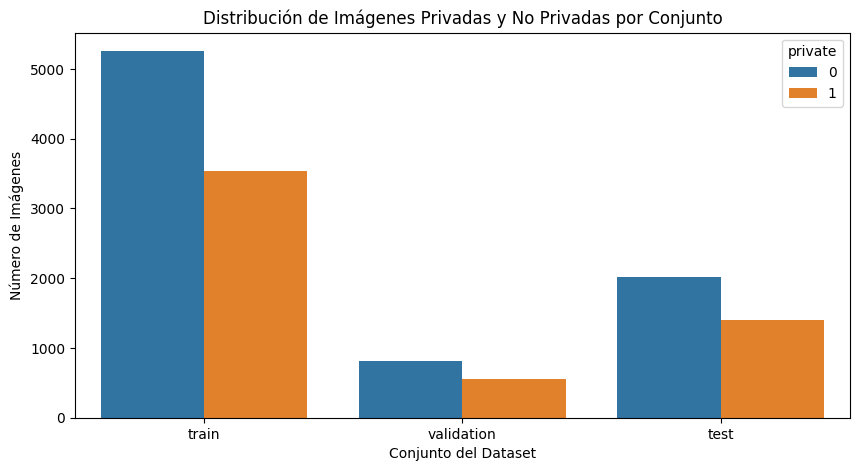

In [ ]:
if not full_df.empty:
    print("\n--- Estadísticas Generales ---")
    # Conteo de imágenes por conjunto
    print("\nConteo de imágenes por conjunto:")
    print(full_df['dataset_split'].value_counts())

    # Distribución de la etiqueta 'private'
    print("\nDistribución de la etiqueta 'private' (global):")
    print(full_df['private'].value_counts(normalize=True) * 100)

    plt.figure(figsize=(10, 5))
    sns.countplot(data=full_df, x='dataset_split', hue='private')
    plt.title('Distribución de Imágenes Privadas y No Privadas por Conjunto')
    plt.ylabel('Número de Imágenes')
    plt.xlabel('Conjunto del Dataset')
    plt.show()
else:
    print("DataFrame 'full_df' vacío, omitiendo estadísticas generales.")


--- Análisis de private_regions ---

DataFrame con columnas expandidas para private_regions:
                        image  private  num_private_regions  \
0  VizWiz_v2_000000031173.jpg        0                    0   
1  VizWiz_v2_000000031174.jpg        0                    0   
2  VizWiz_v2_000000031175.jpg        0                    0   
3  VizWiz_v2_000000031176.jpg        0                    0   
4  VizWiz_v2_000000031177.jpg        1                    2   

                         private_region_classes  
0                                            []  
1                                            []  
2                                            []  
3                                            []  
4  [Text:Computer Screen, Text:Computer Screen]  

Número de imágenes etiquetadas como 'private' pero sin 'private_regions': 0
Número de imágenes NO 'private' pero CON 'private_regions': 0


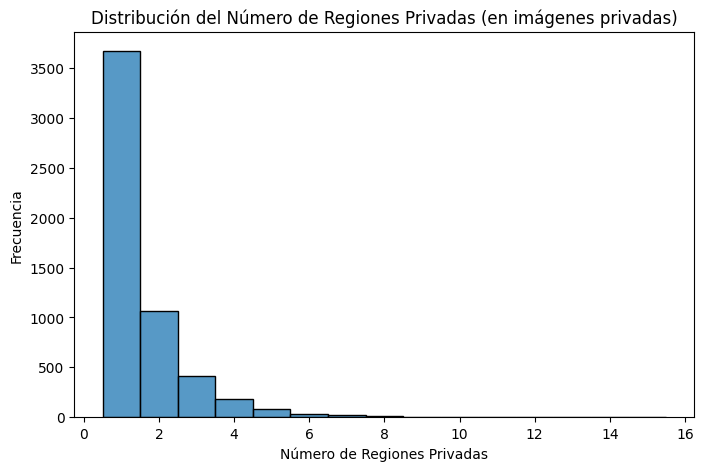


Frecuencia de cada clase de región privada:
Counter({'Object:Face': 2814, 'Text:Miscellaneous Papers': 1497, 'Text:Computer Screen': 663, 'Text:Other': 623, 'Text:Letter': 616, 'Object:Framed Photo': 552, 'Text:Pill Bottle/Box': 350, 'Text:Credit Card': 345, 'Text:Suspicious': 324, 'Text:Business Card': 271, 'Text:Newspaper': 133, 'Object:Face Reflection': 115, 'Text:License Plate': 87, 'Object:Other': 85, 'Text:Receipt': 82, 'Object:Pregnancy Test Result': 67, 'Text:Street Sign': 31, 'Text:Clothing': 29, 'Object:Suspicious': 26, 'Object:Tattoo': 25, 'Text:Menu': 18, 'Text:Poster': 12, 'Text:Book': 6})


/tmp/ipython-input-10-3507728404.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_most_common, y='Clase', x='Frecuencia', palette='viridis')


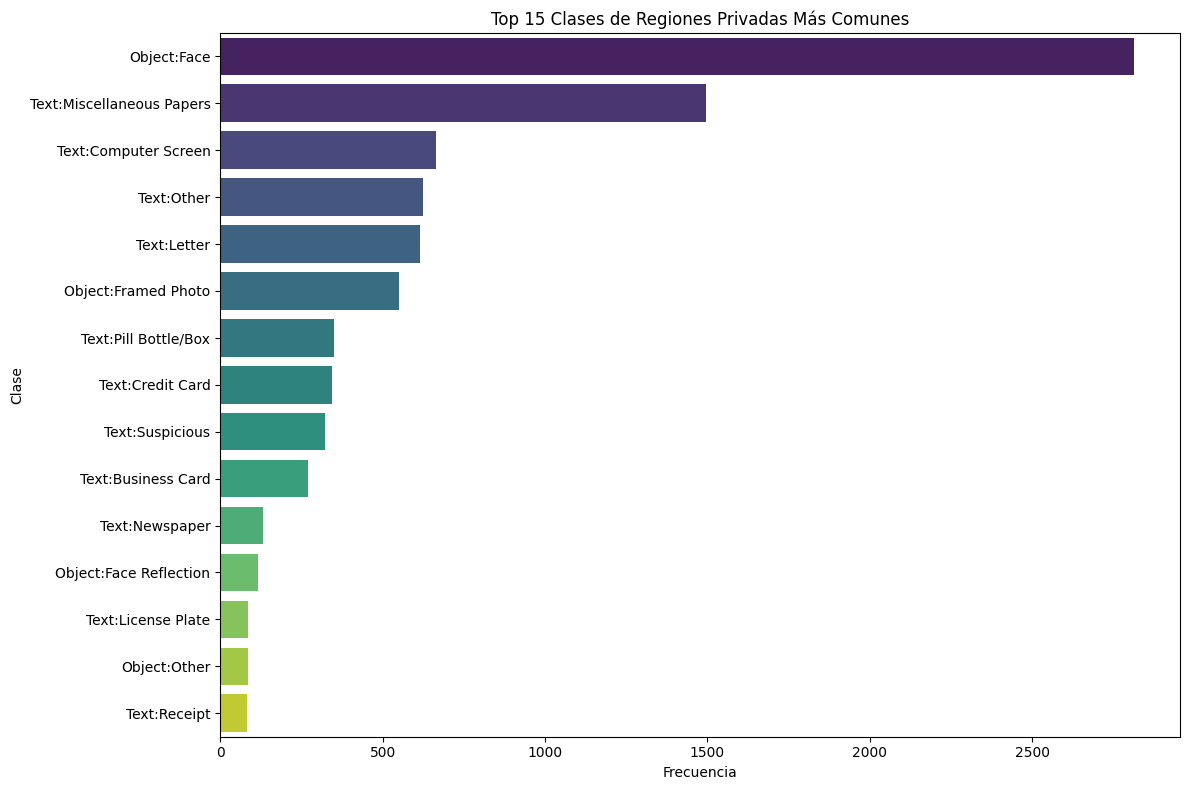

In [ ]:
if not full_df.empty:
    print("\n--- Análisis de private_regions ---")
    # Asegurarse que 'private_regions' existe; si no, crearlo como lista vacía para evitar errores
    if 'private_regions' not in full_df.columns:
        full_df['private_regions'] = [[] for _ in range(len(full_df))]
    else:
        # Rellenar NaN en 'private_regions' con listas vacías si alguna fila no tiene esta clave (poco probable con JSON bien formado)
        full_df['private_regions'] = full_df['private_regions'].apply(lambda x: x if isinstance(x, list) else [])


    full_df['num_private_regions'] = full_df['private_regions'].apply(len)
    full_df['private_region_classes'] = full_df['private_regions'].apply(
        lambda regions: [r['class'] for r in regions if isinstance(r, dict) and 'class' in r]
    )
    full_df['private_region_polygons'] = full_df['private_regions'].apply(
        lambda regions: [r['polygon'] for r in regions if isinstance(r, dict) and 'polygon' in r]
    )

    print("\nDataFrame con columnas expandidas para private_regions:")
    print(full_df[['image', 'private', 'num_private_regions', 'private_region_classes']].head())

    # Consistencia: Imágenes privadas deberían tener regiones
    private_with_no_regions = full_df[(full_df['private'] == 1) & (full_df['num_private_regions'] == 0)]
    print(f"\nNúmero de imágenes etiquetadas como 'private' pero sin 'private_regions': {len(private_with_no_regions)}")

    # Consistencia: Imágenes no privadas no deberían tener regiones
    non_private_with_regions = full_df[(full_df['private'] == 0) & (full_df['num_private_regions'] > 0)]
    print(f"Número de imágenes NO 'private' pero CON 'private_regions': {len(non_private_with_regions)}")

    # Distribución del número de regiones privadas en imágenes que son privadas
    plt.figure(figsize=(8, 5))
    sns.histplot(full_df[full_df['private'] == 1]['num_private_regions'], discrete=True)
    plt.title('Distribución del Número de Regiones Privadas (en imágenes privadas)')
    plt.xlabel('Número de Regiones Privadas')
    plt.ylabel('Frecuencia')
    plt.show()

    # Análisis de Clases de Regiones Privadas
    all_detected_region_classes = []
    for classes_list in full_df[full_df['private'] == 1]['private_region_classes']:
        all_detected_region_classes.extend(classes_list)

    if all_detected_region_classes:
        from collections import Counter
        region_class_counts = Counter(all_detected_region_classes)
        print("\nFrecuencia de cada clase de región privada:")
        print(region_class_counts)

        # Visualizar las N clases más comunes
        N_TOP_CLASSES = 15
        most_common_classes = region_class_counts.most_common(N_TOP_CLASSES)
        if most_common_classes: # Verificar que no esté vacío
            df_most_common = pd.DataFrame(most_common_classes, columns=['Clase', 'Frecuencia'])
            plt.figure(figsize=(12, 8))
            sns.barplot(data=df_most_common, y='Clase', x='Frecuencia', palette='viridis')
            plt.title(f'Top {N_TOP_CLASSES} Clases de Regiones Privadas Más Comunes')
            plt.xlabel('Frecuencia')
            plt.ylabel('Clase')
            plt.tight_layout()
            plt.show()
        else:
            print("No se encontraron clases comunes para graficar.")
    else:
        print("\nNo se encontraron clases de regiones privadas para analizar.")
else:
    print("DataFrame 'full_df' vacío, omitiendo análisis de private_regions.")


--- Análisis de Características de las Imágenes ---

Extensiones de imagen encontradas: {'.png'}

Estadísticas descriptivas de las dimensiones de las imágenes (muestra):
             width       height  channels  aspect_ratio
count   500.000000   500.000000     500.0    500.000000
mean   1051.438000  1333.590000       3.0      0.807794
std     427.031125   434.283135       0.0      0.370118
min      57.000000     8.000000       3.0      0.665666
25%     968.000000  1296.000000       3.0      0.746914
50%     968.000000  1296.000000       3.0      0.750000
75%    1224.000000  1632.000000       3.0      0.750000
max    2592.000000  3264.000000       3.0      7.125000


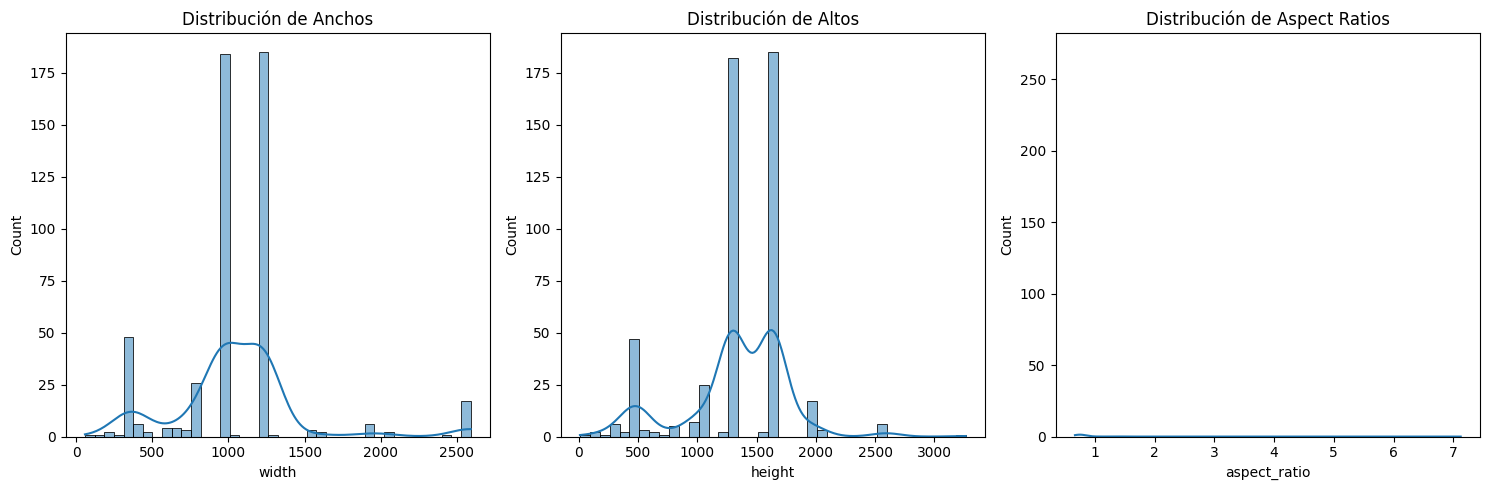

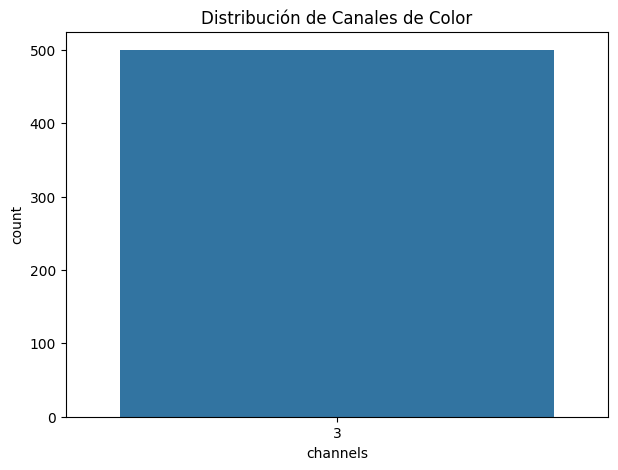

In [ ]:
if not full_df.empty:
    print("\n--- Análisis de Características de las Imágenes ---")
    image_dims = []
    image_extensions = set() # Para ver qué extensiones tienes realmente

    # Procesar una muestra para no tardar demasiado, o todas si es necesario y tienes tiempo
    sample_df = full_df.sample(n=min(500, len(full_df)), random_state=42)

    for index, row in sample_df.iterrows():
        image_filename_json = row['image']
        # IMPORTANTE: Tus JSON dicen .jpg pero tus archivos son .png. Ajusta aquí.
        # Asumimos que el nombre base es el mismo y cambiamos la extensión.
        base_name, _ = os.path.splitext(image_filename_json)
        image_filename_actual = base_name + '.png' # O la extensión que tengan tus archivos

        image_path = os.path.join(IMAGE_DIR, image_filename_actual)

        try:
            with Image.open(image_path) as img:
                width, height = img.size
                channels = len(img.getbands())
                image_dims.append({'width': width, 'height': height, 'channels': channels, 'aspect_ratio': width/height})
                _, ext = os.path.splitext(image_filename_actual)
                image_extensions.add(ext)
        except FileNotFoundError:
            # print(f"Imagen no encontrada: {image_path}") # Puede ser muy verboso
            pass
        except Exception as e:
            # print(f"Error abriendo {image_path}: {e}")
            pass

    if image_dims:
        dims_df = pd.DataFrame(image_dims)
        print(f"\nExtensiones de imagen encontradas: {image_extensions}")
        print("\nEstadísticas descriptivas de las dimensiones de las imágenes (muestra):")
        print(dims_df.describe())

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        sns.histplot(dims_df['width'], kde=True)
        plt.title('Distribución de Anchos')
        plt.subplot(1, 3, 2)
        sns.histplot(dims_df['height'], kde=True)
        plt.title('Distribución de Altos')
        plt.subplot(1, 3, 3)
        sns.histplot(dims_df['aspect_ratio'], kde=True)
        plt.title('Distribución de Aspect Ratios')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(7,5))
        sns.countplot(data=dims_df, x='channels')
        plt.title('Distribución de Canales de Color')
        plt.show()
    else:
        print("No se pudieron procesar dimensiones de imágenes. Verifica la ruta IMAGE_DIR y las extensiones.")
else:
    print("DataFrame 'full_df' vacío, omitiendo análisis de características de imágenes.")


--- Análisis de Polígonos ---


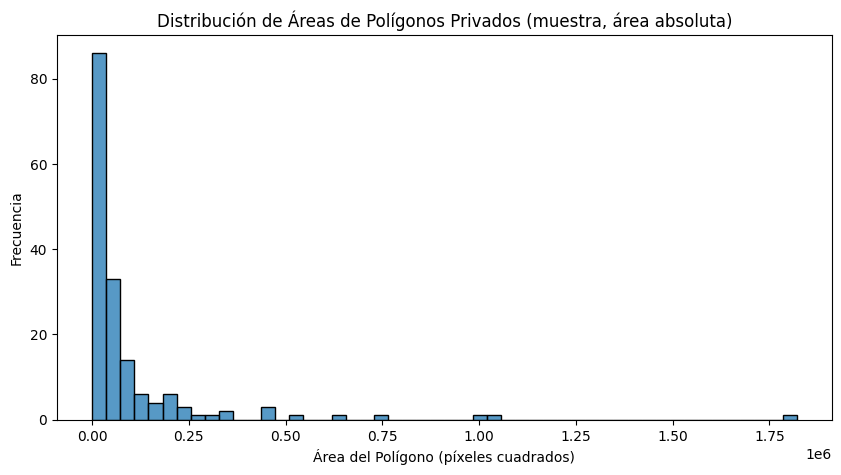


Visualizando algunas imágenes con sus regiones privadas (polígonos y BBoxes):

Mostrando VizWiz_v2_000000043975.png (Clases: ['Object:Face'])


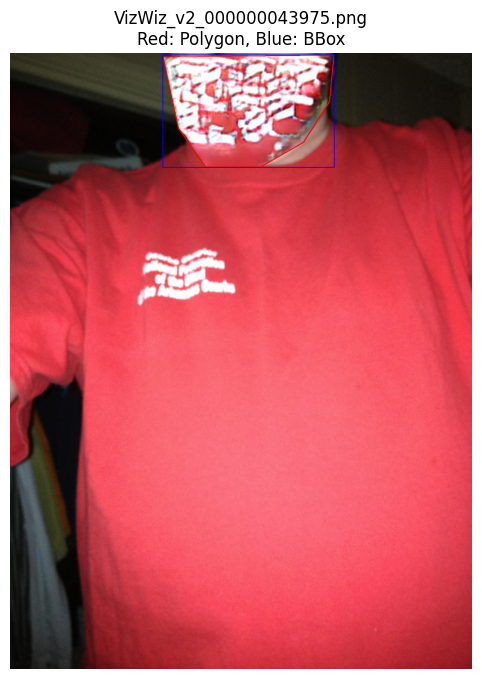


Mostrando VizWiz_v2_000000031382.png (Clases: ['Text:Computer Screen'])


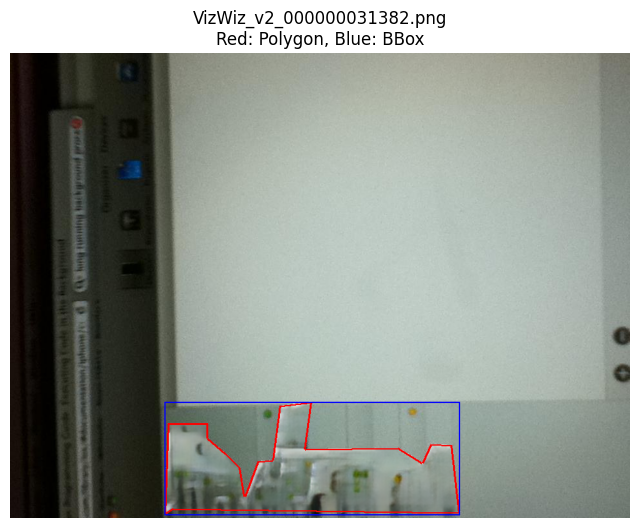


Mostrando VizWiz_v2_000000031252.png (Clases: ['Text:Miscellaneous Papers'])


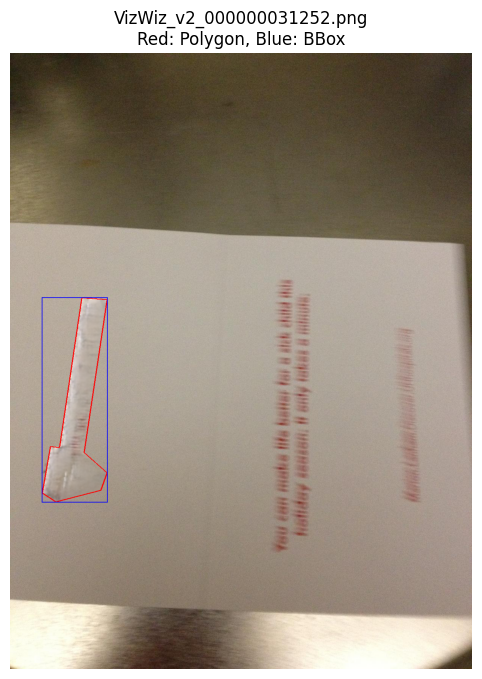

In [ ]:
def polygon_area(vertices):
    """Calcula el área de un polígono usando la fórmula de Shoelace."""
    if not vertices or len(vertices) < 3:
        return 0
    x = np.array([v[0] for v in vertices])
    y = np.array([v[1] for v in vertices])
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def polygon_to_bbox(polygon_vertices):
    """Convierte una lista de vértices de polígono a [xmin, ymin, xmax, ymax]."""
    if not polygon_vertices:
        return None
    x_coords = [p[0] for p in polygon_vertices]
    y_coords = [p[1] for p in polygon_vertices]
    xmin = min(x_coords)
    ymin = min(y_coords)
    xmax = max(x_coords)
    ymax = max(y_coords)
    return [xmin, ymin, xmax, ymax]

if not full_df.empty:
    print("\n--- Análisis de Polígonos ---")
    polygon_areas = []
    images_with_private_regions_df = full_df[full_df['num_private_regions'] > 0].copy() # Usar .copy() para evitar SettingWithCopyWarning

    # Calcular áreas (relativas al tamaño de la imagen si es posible)
    # Para esto, necesitaríamos las dimensiones de cada imagen, lo cual puede ser costoso para todo el dataset.
    # Aquí calculamos el área absoluta del polígono por simplicidad.

    # Usaremos un subconjunto para el cálculo de áreas de polígonos para no tardar mucho
    # Y solo para imágenes que realmente tengan polígonos
    sample_private_regions_df = images_with_private_regions_df.sample(n=min(100, len(images_with_private_regions_df)), random_state=1)

    calculated_polygon_areas = []
    for _, row in sample_private_regions_df.iterrows():
        for polygon in row['private_region_polygons']:
            area = polygon_area(polygon)
            if area > 0: # Considerar solo áreas válidas
                 calculated_polygon_areas.append(area)

    if calculated_polygon_areas:
        plt.figure(figsize=(10, 5))
        sns.histplot(calculated_polygon_areas, bins=50, kde=False)
        plt.title('Distribución de Áreas de Polígonos Privados (muestra, área absoluta)')
        plt.xlabel('Área del Polígono (píxeles cuadrados)')
        plt.ylabel('Frecuencia')
        # Podrías necesitar un scale logarítmico si hay mucha variación
        # plt.xscale('log')
        plt.show()
    else:
        print("No se calcularon áreas de polígonos (quizás no hay polígonos en la muestra o todos tienen área cero).")

    # Visualizar algunas imágenes con sus polígonos y bounding boxes
    print("\nVisualizando algunas imágenes con sus regiones privadas (polígonos y BBoxes):")
    num_images_to_show = 3

    # Filtrar imágenes que son privadas y tienen regiones
    drawable_images_df = full_df[(full_df['private'] == 1) & (full_df['num_private_regions'] > 0)]

    if not drawable_images_df.empty:
        for i, (_, row) in enumerate(drawable_images_df.sample(min(num_images_to_show, len(drawable_images_df)), random_state=42).iterrows()):
            image_filename_json = row['image']
            base_name, _ = os.path.splitext(image_filename_json)
            image_filename_actual = base_name + '.png' # Ajusta la extensión
            image_path = os.path.join(IMAGE_DIR, image_filename_actual)

            try:
                img = Image.open(image_path).convert("RGB") # Convertir a RGB por si acaso
                draw = ImageDraw.Draw(img)

                print(f"\nMostrando {image_filename_actual} (Clases: {row['private_region_classes']})")

                for polygon_verts in row['private_region_polygons']:
                    # Dibujar polígono
                    # ImageDraw.polygon espera una lista plana de coordenadas: [x1,y1,x2,y2,...]
                    flat_polygon = [coord for vert in polygon_verts for coord in vert]
                    draw.polygon(flat_polygon, outline="red", width=3)

                    # Dibujar bounding box
                    bbox = polygon_to_bbox(polygon_verts)
                    if bbox:
                        draw.rectangle(bbox, outline="blue", width=2)

                plt.figure(figsize=(8, 8))
                plt.imshow(img)
                plt.title(f"{image_filename_actual}\nRed: Polygon, Blue: BBox")
                plt.axis('off')
                plt.show()

            except FileNotFoundError:
                print(f"Imagen no encontrada para visualización: {image_path}")
            except Exception as e:
                print(f"Error procesando imagen para visualización {image_path}: {e}")
    else:
        print("No hay imágenes privadas con regiones para mostrar.")
else:
    print("DataFrame 'full_df' vacío, omitiendo análisis de polígonos.")

In [ ]:
if not full_df.empty:
    print("\n--- Verificación de Integridad de Datos (Básica) ---")
    missing_files_count = 0
    checked_files_count = 0

    # Verificar existencia de archivos para una muestra para no tardar demasiado
    # O itera sobre todo full_df['image'] si necesitas una comprobación completa
    sample_filenames_for_check = full_df['image'].sample(min(1000, len(full_df)), random_state=42)

    for image_filename_json in sample_filenames_for_check:
        base_name, _ = os.path.splitext(image_filename_json)
        image_filename_actual = base_name + '.png' # Ajusta la extensión
        image_path = os.path.join(IMAGE_DIR, image_filename_actual)
        checked_files_count +=1
        if not os.path.exists(image_path):
            missing_files_count += 1
            # print(f"Archivo de imagen referenciado en JSON pero no encontrado: {image_path}") # Puede ser muy verboso

    print(f"\nDe {checked_files_count} archivos de imagen verificados (muestra):")
    print(f"Número de archivos de imagen referenciados en JSON pero NO encontrados en {IMAGE_DIR}: {missing_files_count}")

    # Verificar si todas las clases de regiones privadas están en la lista conocida
    all_unique_detected_classes = set()
    if 'private_region_classes' in full_df.columns: # Asegurarse que la columna existe
        for class_list in full_df['private_region_classes']:
            for cls in class_list:
                all_unique_detected_classes.add(cls)

    unknown_classes = all_unique_detected_classes - set(PRIVATE_CLASSES_LIST)
    if unknown_classes:
        print(f"\n¡Advertencia! Se encontraron clases de regiones privadas no listadas en PRIVATE_CLASSES_LIST: {unknown_classes}")
    else:
        print("\nTodas las clases de regiones privadas detectadas están en la lista conocida.")

else:
    print("DataFrame 'full_df' vacío, omitiendo verificación de integridad.")


--- Verificación de Integridad de Datos (Básica) ---

De 1000 archivos de imagen verificados (muestra):
Número de archivos de imagen referenciados en JSON pero NO encontrados en /content/dataset_descomprimido/Filling_Images/: 2

Todas las clases de regiones privadas detectadas están en la lista conocida.


In [ ]:
import os
import pandas as pd

# --- Configuración ---
# Asegúrate de que full_df esté cargado y disponible como en los pasos anteriores del EDA.
# Si no lo está, ejecuta de nuevo la carga de datos.

# Esta es la ruta donde el EDA reportó que no se encontraron los archivos.
# ¡Asegúrate de que esta sea la ruta correcta a tu carpeta de imágenes!
IMAGE_DIR = '/content/dataset_descomprimido/Filling_Images/'

# Asumimos que 'full_df' es tu DataFrame combinado que contiene la columna 'image'
# con los nombres de archivo del JSON (ej., 'VizWiz_v2_000000031173.jpg')

# --- 1. Identificar los archivos faltantes ---
missing_files_info = [] # Para guardar información de los archivos faltantes

print(f"Verificando la existencia de archivos en el directorio: {IMAGE_DIR}")

for index, row in full_df.iterrows():
    image_filename_json = row['image'] # Ej: "VizWiz_v2_000000031173.jpg"

    # Construir el nombre de archivo esperado (cambiando extensión de .jpg a .png)
    base_name, _ = os.path.splitext(image_filename_json)
    image_filename_actual = base_name + '.png' # Asumiendo que los archivos reales son .png

    # Construir la ruta completa al archivo de imagen
    image_path = os.path.join(IMAGE_DIR, image_filename_actual)

    if not os.path.exists(image_path):
        missing_files_info.append({
            'index_in_df': index,
            'json_filename': image_filename_json, # El nombre como está en el JSON
            'expected_actual_filename': image_filename_actual, # El nombre .png que se buscó
            'expected_path': image_path,
            'dataset_split': row.get('dataset_split', 'N/A') # Obtener el split si existe
        })

# --- 2. Mostrar la información de los archivos faltantes ---
if missing_files_info:
    print(f"\nSe encontraron {len(missing_files_info)} archivos de imagen referenciados en el JSON pero no encontrados en el disco:")
    for info in missing_files_info:
        print(f"  - Índice en DataFrame: {info['index_in_df']}, "
              f"Nombre en JSON: {info['json_filename']}, "
              f"Se buscó como: {info['expected_actual_filename']} en {info['expected_path']}, "
              f"Dataset Split: {info['dataset_split']}")

    # Guardar los nombres de archivo JSON de las imágenes faltantes para la eliminación
    json_filenames_to_remove = [info['json_filename'] for info in missing_files_info]

    # --- 3. Eliminar las filas correspondientes del DataFrame full_df ---
    # Contar filas antes de eliminar
    rows_before_removal = len(full_df)

    # Eliminar las filas. Usamos el nombre de archivo original del JSON (columna 'image')
    # que es único y está en json_filenames_to_remove.
    full_df_cleaned = full_df[~full_df['image'].isin(json_filenames_to_remove)].copy() # .copy() para evitar SettingWithCopyWarning

    rows_after_removal = len(full_df_cleaned)

    print(f"\nNúmero de filas en 'full_df' antes de la eliminación: {rows_before_removal}")
    print(f"Número de filas en 'full_df_cleaned' después de la eliminación: {rows_after_removal}")
    print(f"Se eliminaron {rows_before_removal - rows_after_removal} filas.")

    # Opcional: Si quieres sobreescribir tu DataFrame original full_df:
    # full_df = full_df_cleaned
    # print("\nEl DataFrame 'full_df' ha sido actualizado (limpiado).")

    # --- 4. (Opcional) Verificar y limpiar train_df, val_df, test_df ---
    # Si trabajas principalmente con full_df y luego lo divides para entrenar,
    # la limpieza de full_df podría ser suficiente.
    # Si necesitas limpiar los DataFrames individuales (train_df, val_df, test_df)
    # y estos ya existen, puedes hacerlo de manera similar:

    if 'train_df' in globals() and not train_df.empty:
        train_df_cleaned = train_df[~train_df['image'].isin(json_filenames_to_remove)].copy()
        if len(train_df) != len(train_df_cleaned):
            print(f"Filas eliminadas de train_df: {len(train_df) - len(train_df_cleaned)}")
            # train_df = train_df_cleaned # Descomenta para actualizar

    if 'val_df' in globals() and not val_df.empty:
        val_df_cleaned = val_df[~val_df['image'].isin(json_filenames_to_remove)].copy()
        if len(val_df) != len(val_df_cleaned):
            print(f"Filas eliminadas de val_df: {len(val_df) - len(val_df_cleaned)}")
            # val_df = val_df_cleaned # Descomenta para actualizar

    if 'test_df' in globals() and not test_df.empty:
        test_df_cleaned = test_df[~test_df['image'].isin(json_filenames_to_remove)].copy()
        if len(test_df) != len(test_df_cleaned):
            print(f"Filas eliminadas de test_df: {len(test_df) - len(test_df_cleaned)}")
            # test_df = test_df_cleaned # Descomenta para actualizar

    # A partir de aquí, usa 'full_df_cleaned' (o 'full_df' si lo sobreescribiste)
    # y las versiones limpias de train_df, val_df, test_df para los siguientes pasos.

else:
    print("\nNo se encontraron archivos faltantes según la verificación actual. "
          "Asegúrate de que IMAGE_DIR esté configurado correctamente y que los nombres de archivo se estén construyendo como se espera.")

Verificando la existencia de archivos en el directorio: /content/dataset_descomprimido/Filling_Images/

Se encontraron 8 archivos de imagen referenciados en el JSON pero no encontrados en el disco:
  - Índice en DataFrame: 4663, Nombre en JSON: VizWiz_v2_000000035838.jpg, Se buscó como: VizWiz_v2_000000035838.png en /content/dataset_descomprimido/Filling_Images/VizWiz_v2_000000035838.png, Dataset Split: train
  - Índice en DataFrame: 10528, Nombre en JSON: VizWiz_v2_000000040151.jpg, Se buscó como: VizWiz_v2_000000040151.png en /content/dataset_descomprimido/Filling_Images/VizWiz_v2_000000040151.png, Dataset Split: test
  - Índice en DataFrame: 10616, Nombre en JSON: VizWiz_v2_000000040352.jpg, Se buscó como: VizWiz_v2_000000040352.png en /content/dataset_descomprimido/Filling_Images/VizWiz_v2_000000040352.png, Dataset Split: test
  - Índice en DataFrame: 11084, Nombre en JSON: VizWiz_v2_000000041165.jpg, Se buscó como: VizWiz_v2_000000041165.png en /content/dataset_descomprimido/Filli

In [ ]:
import os
import numpy as np
from PIL import Image # Pillow para manejo de imágenes
import pandas as pd # Solo si necesitas recargar full_df_cleaned

# --- Configuración ---
# Asegúrate de que full_df_cleaned (o train_df_cleaned, val_df_cleaned, test_df_cleaned)
# esté disponible. Si no, cárgalo o ejecútalo desde el paso anterior.
# Ejemplo: Si necesitas cargar el DataFrame limpio (si no está en memoria)
# full_df_cleaned = pd.read_pickle('full_df_cleaned.pkl') # Si lo guardaste previamente
# O asegúrate de que la variable full_df_cleaned del paso anterior esté accesible.



# --- 1. Seleccionar una imagen de ejemplo y mostrarla como matriz ---

# Vamos a tomar la primera imagen del DataFrame limpio como ejemplo
if 'full_df_cleaned' in globals() and not full_df_cleaned.empty:
    sample_image_info = full_df_cleaned.iloc[0] # Tomamos la primera fila
    image_filename_json = sample_image_info['image']

    # Construir el nombre de archivo esperado (cambiando extensión de .jpg a .png)
    base_name, _ = os.path.splitext(image_filename_json)
    image_filename_actual = base_name + '.png' # Asumiendo que los archivos reales son .png

    sample_image_path = os.path.join(IMAGE_DIR, image_filename_actual)

    print(f"--- Imagen de Ejemplo: {image_filename_actual} ---")

    try:
        # Cargar la imagen
        img = Image.open(sample_image_path)

        # Convertir la imagen a una matriz NumPy
        img_array = np.array(img)

        print(f"\nDimensiones de la imagen de ejemplo (Altura, Anchura, Canales): {img_array.shape}")

        print("\nValores numéricos (matriz de píxeles) de la imagen de ejemplo (primeros 5x5 píxeles de cada canal si es color):")
        if img_array.ndim == 3: # Imagen a color (Altura, Anchura, Canales)
            print("Canal 0 (Rojo):")
            print(img_array[:5, :5, 0])
            if img_array.shape[2] > 1:
                print("\nCanal 1 (Verde):")
                print(img_array[:5, :5, 1])
            if img_array.shape[2] > 2:
                print("\nCanal 2 (Azul):")
                print(img_array[:5, :5, 2])
        elif img_array.ndim == 2: # Imagen en escala de grises (Altura, Anchura)
            print(img_array[:5, :5])
        else:
            print("Formato de array de imagen no reconocido para mostrar como matriz.")

    except FileNotFoundError:
        print(f"Error: No se pudo encontrar la imagen de ejemplo en {sample_image_path}")
    except Exception as e:
        print(f"Ocurrió un error al procesar la imagen de ejemplo: {e}")
else:
    print("El DataFrame 'full_df_cleaned' no está disponible o está vacío.")

print("\n" + "="*50 + "\n") # Separador

# --- 2. Mostrar dimensiones para un conjunto de imágenes (ej. el conjunto de prueba) ---

# Elegimos un DataFrame para iterar, por ejemplo, test_df_cleaned.
# Asegúrate de que test_df_cleaned esté definido y limpio.
# Si no, puedes crearlo filtrando full_df_cleaned:
# test_df_to_check = full_df_cleaned[full_df_cleaned['dataset_split'] == 'test']
# O usar uno de los _cleaned del paso anterior:
if 'test_df_cleaned' in globals() and not test_df_cleaned.empty:
    df_to_iterate = test_df_cleaned
    dataset_name = "test_df_cleaned"
elif 'full_df_cleaned' in globals() and not full_df_cleaned.empty:
    # Si test_df_cleaned no está, toma una muestra más pequeña de full_df_cleaned para demostración
    df_to_iterate = full_df_cleaned.sample(min(100, len(full_df_cleaned)), random_state=42) # Muestra de 100 o menos
    dataset_name = "una muestra de full_df_cleaned"
    print(f"ADVERTENCIA: 'test_df_cleaned' no encontrado o vacío. Usando {dataset_name} en su lugar.")
else:
    df_to_iterate = pd.DataFrame() # DataFrame vacío para evitar errores
    dataset_name = "ningún conjunto de datos disponible"
    print("ADVERTENCIA: No hay DataFrames limpios disponibles para mostrar dimensiones de múltiples imágenes.")


if not df_to_iterate.empty:
    print(f"--- Dimensiones de las imágenes en {dataset_name} ---")

    all_image_shapes = []
    images_not_found_count = 0

    for index, row in df_to_iterate.iterrows():
        image_filename_json = row['image']
        base_name, _ = os.path.splitext(image_filename_json)
        image_filename_actual = base_name + '.png'
        image_path = os.path.join(IMAGE_DIR, image_filename_actual)

        try:
            with Image.open(image_path) as img:
                img_array_loop = np.array(img)
                all_image_shapes.append(img_array_loop.shape)
        except FileNotFoundError:
            images_not_found_count += 1
            # Puedes imprimir un mensaje por cada no encontrado si lo deseas, pero puede ser verboso
            # print(f"No se encontró: {image_path}")
        except Exception as e:
            # print(f"Error abriendo {image_path}: {e}") # También puede ser verboso
            pass # Ignorar otros errores de carga por ahora para el resumen

    print(f"\nNúmero total de imágenes procesadas en '{dataset_name}': {len(df_to_iterate)}")
    print(f"Número de estas imágenes que no se pudieron encontrar en disco: {images_not_found_count}")

    if all_image_shapes:
        print(f"Dimensiones encontradas (Altura, Anchura, Canales) para {len(all_image_shapes)} imágenes:")
        # Mostrar las primeras N dimensiones para no saturar la salida
        N_SHAPES_TO_SHOW = 10
        for i, shape in enumerate(all_image_shapes[:N_SHAPES_TO_SHOW]):
            print(f"  Imagen {i+1}: {shape}")
        if len(all_image_shapes) > N_SHAPES_TO_SHOW:
            print(f"  ... y {len(all_image_shapes) - N_SHAPES_TO_SHOW} más.")

        # Si todas las imágenes tuvieran exactamente las mismas dimensiones después de un preprocesamiento (ej. redimensionamiento),
        # podrías representar el conjunto como (N, H, W, C).
        # Por ejemplo, si todas fueran (128, 128, 3):
        # num_images = len(all_image_shapes)
        # if num_images > 0 and len(set(all_image_shapes)) == 1: # Verifica si todas las formas son idénticas
        #     common_shape = all_image_shapes[0]
        #     print(f"\nTodas las {num_images} imágenes procesadas tienen la misma forma: {common_shape}")
        #     print(f"Podrías pensar en este conjunto como un tensor de forma: ({num_images}, {common_shape[0]}, {common_shape[1]}, {common_shape[2] if len(common_shape) == 3 else 1})")
        # else:
        #     print("\nLas imágenes en este conjunto tienen dimensiones variables.")
        #     print("Para obtener una forma única como (N, H, W, C), necesitarás redimensionarlas a un tamaño común "
        #           "durante el preprocesamiento.")

        # Conteo de formas únicas para entender la variabilidad
        from collections import Counter
        shape_counts = Counter(all_image_shapes)
        print("\nResumen de formas únicas y sus conteos:")
        for shape, count in shape_counts.items():
            print(f"  Forma {shape}: {count} imágenes")

    else:
        print(f"No se pudieron obtener dimensiones para las imágenes en '{dataset_name}'.")

else:
    print("No se procesaron dimensiones para múltiples imágenes porque el DataFrame a iterar estaba vacío.")

--- Imagen de Ejemplo: VizWiz_v2_000000031173.png ---

Dimensiones de la imagen de ejemplo (Altura, Anchura, Canales): (1632, 1224, 3)

Valores numéricos (matriz de píxeles) de la imagen de ejemplo (primeros 5x5 píxeles de cada canal si es color):
Canal 0 (Rojo):
[[15 16 18 19 20]
 [18 17 16 15 15]
 [21 18 14 11 10]
 [19 17 14 12 10]
 [14 14 15 15 15]]

Canal 1 (Verde):
[[16 17 19 20 21]
 [19 18 17 16 16]
 [22 19 15 12 11]
 [20 18 15 13 11]
 [15 15 16 16 16]]

Canal 2 (Azul):
[[11 12 14 15 16]
 [14 13 12 11 11]
 [17 14 10  7  6]
 [15 13 10  8  6]
 [10 10 11 11 11]]


--- Dimensiones de las imágenes en test_df_cleaned ---

Número total de imágenes procesadas en 'test_df_cleaned': 3402
Número de estas imágenes que no se pudieron encontrar en disco: 0
Dimensiones encontradas (Altura, Anchura, Canales) para 3402 imágenes:
  Imagen 1: (1296, 968, 3)
  Imagen 2: (1632, 1224, 3)
  Imagen 3: (960, 720, 3)
  Imagen 4: (1296, 968, 3)
  Imagen 5: (1296, 968, 3)
  Imagen 6: (2048, 1536, 3)
  Image